## Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as st
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import  roc_auc_score, roc_curve

sns.set_theme(
    context='notebook',
    style='darkgrid',
    palette='deep',
)

## Leitura e tratamento inicial

In [2]:
data = pd.read_csv('data_test_DS.csv')

In [3]:
data.head()

,Nº do cliente,Safra,Estado,Renda Mensal,Endividamento,Quantidade de Cheques sem Fundo,Quantidade de Restritivos,Valor dos Restritivos,Quantidade de Protestos,Valor dos Protestos,Modelo Score 1,Modelo Score 2,Modelo Score 3,Modelo Score 4,Performance 30D3M EVER,Performance 60D6M EVER,Performance 60D9M EVER,Performance 90D9M EVER,Performance 90D12M EVER
0,6.325851e+08,2020-05-01 00:00:00 UTC,MS,1076.0,26 a 50%,0.0,2.0,418.0,0.0,0.0,141.0,236.0,196.0,405.0,BOM,MAU,MAU,MAU,MAU
1,1.190978e+09,2020-05-01 00:00:00 UTC,MG,12709.0,Até 25%,0.0,0.0,0.0,0.0,0.0,767.0,646.0,805.0,946.0,BOM,BOM,BOM,BOM,BOM
2,1.089165e+09,2020-06-01 00:00:00 UTC,MS,2518.0,Acima de 100%,0.0,4.0,32306.0,0.0,0.0,67.0,238.0,196.0,563.0,BOM,BOM,BOM,BOM,BOM
3,1.342327e+08,2020-05-01 00:00:00 UTC,RS,1090.0,Até 25%,0.0,0.0,0.0,0.0,0.0,245.0,523.0,290.0,698.0,MAU,BOM,MAU,BOM,MAU
4,1.055186e+09,2020-10-01 00:00:00 UTC,RJ,1155.0,Até 25%,0.0,0.0,0.0,0.0,0.0,697.0,718.0,645.0,816.0,BOM,BOM,NaN,NaN,NaN


In [4]:
# Normalizar nome das colunas
def normalize_col_name(name: str) -> str:

    """Transforma o nome da coluna em um nome normalizado sem espaços e caracteres especiais.

    Args:
        name: `str`
            Nome de uma coluna da base de dados.

    Returns:
        name: `str`
            Nome de uma coluna normalizado sem espaços e caracteres especiais.
    """

    name = name.lower()
    name = name.replace(' ', '_')
    name = name.replace('º', '')
    return name

# Aplicar normalização
data.columns = [normalize_col_name(col) for col in data.columns]

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11994 entries, 0 to 11993
Data columns (total 19 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   n_do_cliente                     10000 non-null  float64
 1   safra                            10000 non-null  object 
 2   estado                           10000 non-null  object 
 3   renda_mensal                     10000 non-null  float64
 4   endividamento                    10000 non-null  object 
 5   quantidade_de_cheques_sem_fundo  10000 non-null  float64
 6   quantidade_de_restritivos        10000 non-null  float64
 7   valor_dos_restritivos            10000 non-null  float64
 8   quantidade_de_protestos          10000 non-null  float64
 9   valor_dos_protestos              10000 non-null  float64
 10  modelo_score_1                   10000 non-null  float64
 11  modelo_score_2                   10000 non-null  float64
 12  modelo_score_3    

As primeiras 16 colunas possuem 1994 registros nulos em alguma posição. Observando no csv pode-se ver que existem muitas linhas completamente nulas ou só com a última coluna preenchida.

In [6]:
# Remoção de valores nulos que se estendem por completo nas linhas em colunas que não são variáveis resposta
cols = ['n_do_cliente', 'safra', 'estado', 'renda_mensal', 'endividamento',
       'quantidade_de_cheques_sem_fundo', 'quantidade_de_restritivos',
       'valor_dos_restritivos', 'quantidade_de_protestos',
       'valor_dos_protestos',]
data = data.dropna(how='all', subset=cols)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   n_do_cliente                     10000 non-null  float64
 1   safra                            10000 non-null  object 
 2   estado                           10000 non-null  object 
 3   renda_mensal                     10000 non-null  float64
 4   endividamento                    10000 non-null  object 
 5   quantidade_de_cheques_sem_fundo  10000 non-null  float64
 6   quantidade_de_restritivos        10000 non-null  float64
 7   valor_dos_restritivos            10000 non-null  float64
 8   quantidade_de_protestos          10000 non-null  float64
 9   valor_dos_protestos              10000 non-null  float64
 10  modelo_score_1                   10000 non-null  float64
 11  modelo_score_2                   10000 non-null  float64
 12  modelo_score_3     

É possível ver que foram removidas as 1994 linhas que estavam quase ou completamente nulas.

In [8]:
data.__len__() # Número de instâncias na base de dados

10000

## Análise Descritiva

### Análise das variáveis resposta
Aqui analiso as variáveis resposta categóricas com a intenção de fazer um modelo preditivo para classificação.

Após observar os gráficos, valores e quantidades de instâncias na base: na performance relativa a inadimplência por mais de 60 dias num período de 90 dias percebe-se uma maior concentração de indicadores ruins. Esse pode ser um ponto de atenção para a empresa, visto que nesse período de tempo e padrão de comportamento o risco de inadimplência é maior. Ainda, considerando períodos de inadimplência superiores a 90 dias no mesmo período de observação a proporção de indicadores ruim é menor, o que pode sugerir que existe potencial de redução nesse período. Mesmo com instâncias de dados não rotuladas a quantidade de dados não é significantemente menor que a quantidade de dados totais >8000.

Com as considerações acima, utilizarei a variável resposta `Performance 60D9M EVER` para fazer um modelo para classificação. As análises serão feitas em função dela.

,performance_30d3m_ever
BOM,0.8756
MAU,0.1244


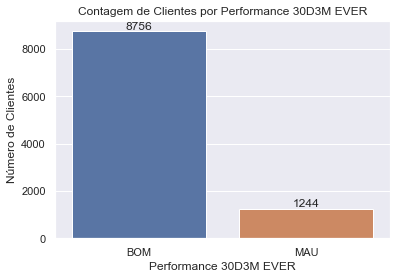

In [9]:
ax = sns.countplot(data=data, x='performance_30d3m_ever', order=data['performance_60d6m_ever'].value_counts().index)
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='top', xytext=(0, 10), textcoords='offset points')
plt.xlabel('Performance 30D3M EVER')
plt.ylabel('Número de Clientes')
plt.title('Contagem de Clientes por Performance 30D3M EVER');
data.performance_30d3m_ever.value_counts(normalize=True).to_frame()

,performance_60d6m_ever
BOM,0.829
MAU,0.171


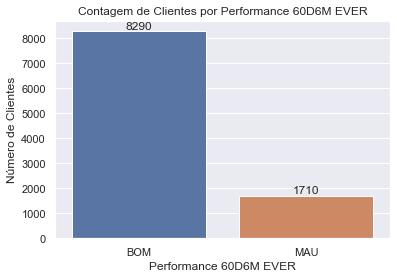

In [10]:
ax = sns.countplot(data=data, x='performance_60d6m_ever', order=data['performance_60d6m_ever'].value_counts().index)
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='top', xytext=(0, 10), textcoords='offset points')
plt.xlabel('Performance 60D6M EVER')
plt.ylabel('Número de Clientes')
plt.title('Contagem de Clientes por Performance 60D6M EVER');
data.performance_60d6m_ever.value_counts(normalize=True).to_frame()

,performance_60d9m_ever
BOM,0.766647
MAU,0.233353


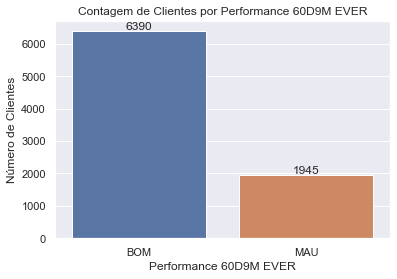

In [11]:
ax = sns.countplot(data=data, x='performance_60d9m_ever', order=data['performance_60d9m_ever'].value_counts().index)
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='top', xytext=(0, 10), textcoords='offset points')
plt.xlabel('Performance 60D9M EVER')
plt.ylabel('Número de Clientes')
plt.title('Contagem de Clientes por Performance 60D9M EVER');
data.performance_60d9m_ever.value_counts(normalize=True).to_frame()

,performance_90d9m_ever
BOM,0.812238
MAU,0.187762


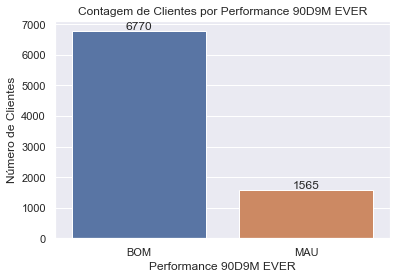

In [12]:
ax = sns.countplot(data=data, x='performance_90d9m_ever', order=data['performance_90d9m_ever'].value_counts().index)
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='top', xytext=(0, 10), textcoords='offset points')
plt.xlabel('Performance 90D9M EVER')
plt.ylabel('Número de Clientes')
plt.title('Contagem de Clientes por Performance 90D9M EVER');
data.performance_90d9m_ever.value_counts(normalize=True).to_frame()

,performance_90d12m_ever
BOM,0.762671
MAU,0.237329


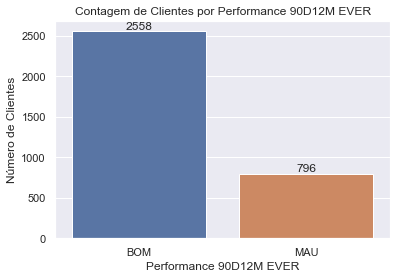

In [13]:
ax = sns.countplot(data=data, x='performance_90d12m_ever', order=data['performance_90d12m_ever'].value_counts().index)
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='top', xytext=(0, 10), textcoords='offset points')
plt.xlabel('Performance 90D12M EVER')
plt.ylabel('Número de Clientes')
plt.title('Contagem de Clientes por Performance 90D12M EVER');
data.performance_90d12m_ever.value_counts(normalize=True).to_frame()

In [14]:
target = 'performance_60d9m_ever'
cols = ['n_do_cliente', 'modelo_score_1', 'modelo_score_2', 'modelo_score_3', 'modelo_score_4', 'performance_30d3m_ever', 'performance_60d6m_ever', 'performance_90d9m_ever', 'performance_90d12m_ever']
data = data.drop(cols, axis=1).dropna(subset=[target],)

### Safra
Número de safras das quais, no período, se originaram os clientes aprovados. Um período de 6 meses no ano de 2020. O campo pode ser convertido para um inteiro ou nome do mês. Observa-se que houve um aumento no indicador de inadimplência no mês de agosto.

In [15]:
data.safra = data.safra.map(lambda x: x[5:7])

In [16]:
hue_order = data.performance_60d9m_ever.value_counts().index # Para ordenar os valores de cor nos gráficos

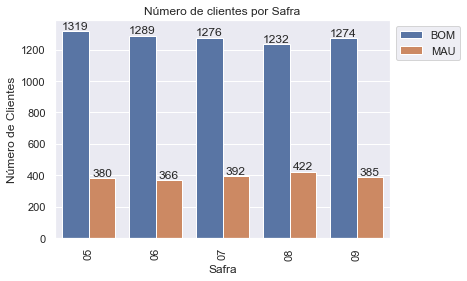

In [17]:
ax = sns.countplot(data=data, x='safra', order=data['safra'].value_counts().index.sort_values(), hue=target, hue_order=hue_order)
# Annotate the plot
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='top', xytext=(0, 10), textcoords='offset points')
plt.xticks(rotation=90)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xlabel('Safra')
plt.ylabel('Número de Clientes')
plt.title('Número de clientes por Safra');

### Estado
São evidenciados os estados e região com maior concentração de clientes, podendo receber mais investimento na manutenção do relacionamento com os clientes. Por outro lado os estados com pouca atividade poderiam receber investimentos focados na captação de bons clientes, principalmente nas regiões Norte e Nordeste -- uma possibilidade de expansão. 

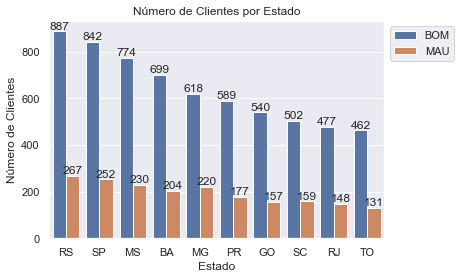

In [18]:
ax = sns.countplot(data=data, x='estado', order=data['estado'].value_counts().index, hue=target, hue_order=hue_order)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
# Annotate the plot
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='top', xytext=(0, 10), textcoords='offset points')
# plt.xticks(rotation=90)
plt.xlabel('Estado')
plt.ylabel('Número de Clientes')
plt.title('Número de Clientes por Estado');

In [19]:
# agrupar estados por região
def regiao_estado(estado):
    uf_sul = ['RS', 'SC', 'PR']
    uf_sudeste = ['ES', 'RJ', 'SP', 'MG']
    uf_centro_oeste = ['GO', 'DF', 'MT', 'MS']
    uf_norte = ['AC', 'AM', 'PA', 'AP', 'RO', 'RR', 'TO']

    if estado in uf_sul:
        return 'Sul'
    elif estado in uf_sudeste:
        return 'Sudeste'
    elif estado in uf_centro_oeste:
        return 'Centro-Oeste'
    elif estado in uf_norte:
        return 'Norte'
    else:
        return 'Nordeste'

data['regiao'] = data.estado.map(regiao_estado)

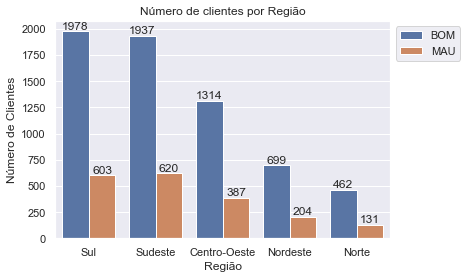

In [20]:
ax = sns.countplot(data=data, x='regiao', order=data['regiao'].value_counts().index, hue=target, hue_order=hue_order)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
# Annotate the plot
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='top', xytext=(0, 10), textcoords='offset points')
# plt.xticks(rotation=90)
plt.xlabel('Região')
plt.ylabel('Número de Clientes')
plt.title('Número de clientes por Região');

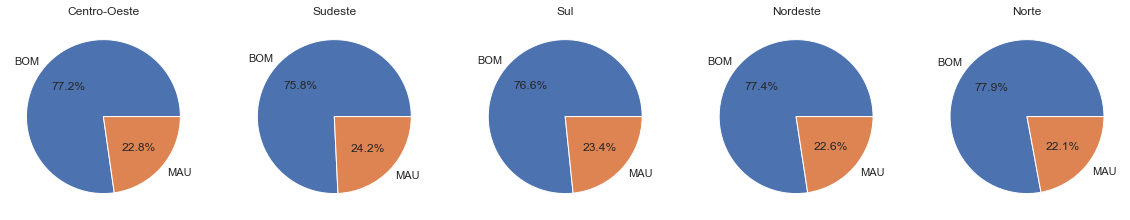

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(20, 5))
for i, regiao in enumerate(data.regiao.unique()):
    data_regiao = data[data.regiao == regiao]
    ax[i].pie(data_regiao.performance_60d9m_ever.value_counts(), labels=data_regiao.performance_60d9m_ever.value_counts().index, autopct='%1.1f%%')
    ax[i].set_title(regiao)

### Renda Mensal
Na descrição das medidas de tendência central e no histograma observam-se que a renda mensal é um atributo que pode ser afetado pela magnitude de poucos pontos aberrantes.

In [22]:
data.renda_mensal.describe().to_frame()

,renda_mensal
count,8335.000000
mean,2774.036113
std,1488.845874
min,1041.000000
25%,1403.000000
50%,3310.000000
75%,3492.000000
max,33564.000000


4.236705914893795


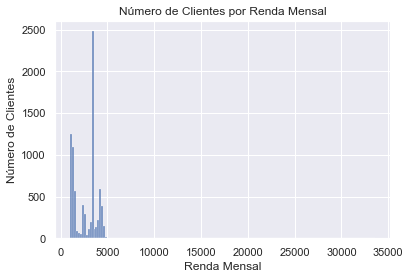

In [23]:
sns.histplot(data=data, x='renda_mensal')
plt.xlabel('Renda Mensal')
plt.ylabel('Número de Clientes')
plt.title('Número de Clientes por Renda Mensal');
print(data.renda_mensal.skew())

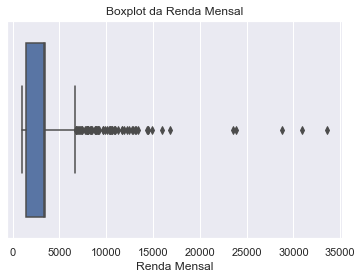

In [24]:
sns.boxplot(x=data['renda_mensal'])
plt.xlabel('Renda Mensal')
plt.title('Boxplot da Renda Mensal');

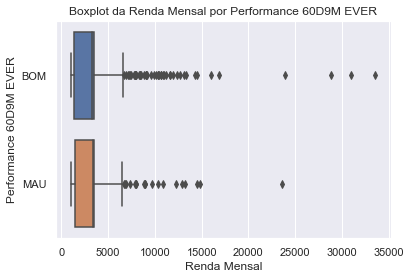

In [25]:
sns.boxplot(data=data, x='renda_mensal', y=target, order=hue_order)
plt.xlabel('Renda Mensal')
plt.ylabel('Performance 60D9M EVER')
plt.title('Boxplot da Renda Mensal por Performance 60D9M EVER');

Aqui um tratamento pode ser necessário para a Renda Mensal ao observar o histograma com uma assimetria positiva de 4.27. Existem poucos valores distribuidos pela cauda positiva do histograma. A boxplot reforça a presença de outliers na coluna.

In [26]:
def iqr_filter(data:pd.DataFrame, col:str) -> list[bool]:
    """iqr_filter
        Função para gerar um filtro dos dados de uma coluna com base no IQR
    Args:
        data (pd.DataFrame): DataFrame com os dados
        col (str): Coluna a ser filtrada

    Returns:
        list[bool]: Um array de booleanos que pode selecionar os valores que estão dentro do intervalo de interquartil
    """
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    return (data[col] >= Q1 - 1.5 * IQR) & (data[col] <= Q3 + 1.5 * IQR)

In [27]:
outliers = data[~iqr_filter(data, 'renda_mensal')]
inliers = data[iqr_filter(data, 'renda_mensal')]

print(inliers.__len__()/data.__len__(), outliers.__len__()/data.__len__()) # Proporção de inliers/outliers
print(inliers.__len__(), outliers.__len__()) # Número de inliers/outliers

0.9920815836832634 0.007918416316736652
8269 66


Com a análise acima, pode-se observar que os outliers representam >0.01% das instâncias. O tratamento a ser feito aqui é remover os outliers, que estão em pequena quantidade.

In [28]:
data = data[iqr_filter(data, 'renda_mensal')]

In [29]:
data.renda_mensal.describe().to_frame()

,renda_mensal
count,8269.000000
mean,2705.447938
std,1183.438075
min,1041.000000
25%,1399.000000
50%,3305.000000
75%,3492.000000
max,6613.000000


-0.04208923010832355


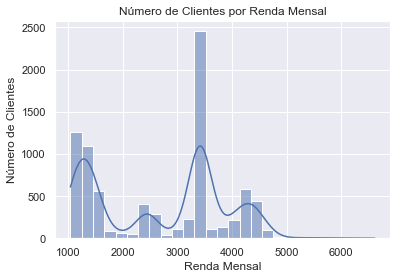

In [30]:
sns.histplot(data=data, x='renda_mensal', kde=True)
plt.xlabel('Renda Mensal')
plt.ylabel('Número de Clientes')
plt.title('Número de Clientes por Renda Mensal');
print(data.renda_mensal.skew())

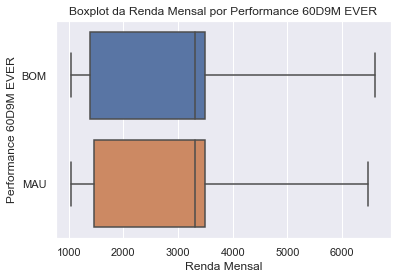

In [31]:
sns.boxplot(data=data, x='renda_mensal', y=target, order=hue_order)
plt.xlabel('Renda Mensal')
plt.ylabel('Performance 60D9M EVER')
plt.title('Boxplot da Renda Mensal por Performance 60D9M EVER');

A remoção dos pontos aberrantes trouxe melhoras para a visualização dos gráficos e para o entendimento da variável Renda Mensal -- ela não segue uma distribuição nomal. No entanto, a distribuição dos valores de renda para as duas categorias é muito semelhante --  a mediana das duas distribuições é praticamente a mesma, mas o máximo dos clientes em MAU é menor que os de clientes em BOM. Calcula-se, então, a correlação se Spearman entre essas variáveis:

In [32]:
# Transformar a variável resposta um valor numérico
data['target'] = pd.get_dummies(data.performance_60d9m_ever)['MAU'] # 1 = MAU, 0 = BOM

In [33]:
st.spearmanr(data.renda_mensal, data.target)

SpearmanrResult(correlation=0.0321995917397272, pvalue=0.0034076001696093493)

Pode então se concluir que a correlação entre Renda Mensal e a Performance é positiva e fraca, seguindo o comportamento entre as distribuições no boxplot.

### Endividamento

In [34]:
data.endividamento.value_counts(normalize=True).to_frame()

,endividamento
Até 25%,0.783892
Acima de 100%,0.124683
26 a 50%,0.042931
51 a 75%,0.029024
76 a 100%,0.019470


In [35]:
# Transformar endividamento
data.endividamento = data.endividamento.map({'26 a 50%':'até 50%', 'Acima de 100%':'mais de 100%', 'Até 25%': 'até 25%', '51 a 75%': 'até 75%', '76 a 100%': 'até 100%'})

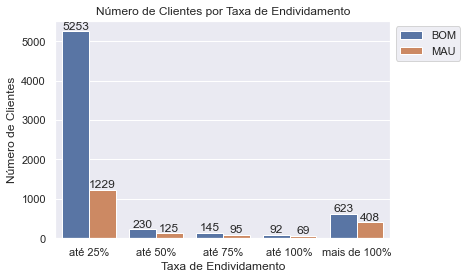

In [36]:
ax = sns.countplot(x='endividamento', data=data, order=['até 25%', 'até 50%', 'até 75%', 'até 100%', 'mais de 100%'], hue=target, hue_order=hue_order) # A taxa de endividamento se encontra nos extremos da base
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
# Annotate the plot
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='top', xytext=(0, 10), textcoords='offset points')
# plt.xticks(rotation=90)
plt.xlabel('Taxa de Endividamento')
plt.ylabel('Número de Clientes')
plt.title('Número de Clientes por Taxa de Endividamento');

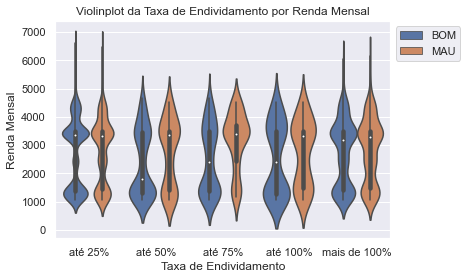

In [37]:
sns.violinplot(data=data, x='endividamento', y='renda_mensal', hue=target, order=['até 25%', 'até 50%', 'até 75%', 'até 100%', 'mais de 100%'], hue_order=hue_order)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xlabel('Taxa de Endividamento')
plt.ylabel('Renda Mensal')
plt.title('Violinplot da Taxa de Endividamento por Renda Mensal');

Inicialmente se observa que a maior parte dos clientes se encontram com até 25% ou mais que 100% da renda comprometida e que a distribuição da renda mensal é muito semelhante em todas as faixas de endividamento. Para melhorar a análise, calcula-se a renda mensal livre e a renda mensal comprometida.

In [38]:
map_endividamento_max = data.endividamento.map({'até 50%': .50, 'mais de 100%': 1.00, 'até 25%': .25, 'até 75%': .75, 'até 100%': 1.00})
data['renda_livre'] = data.renda_mensal - (data.renda_mensal * map_endividamento_max)
data['renda_comprometida'] = data.renda_mensal * map_endividamento_max

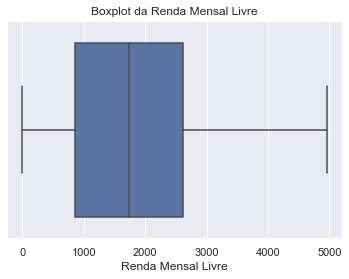

In [39]:
sns.boxplot(data=data, x='renda_livre')
plt.xlabel('Renda Mensal Livre')
plt.title('Boxplot da Renda Mensal Livre');

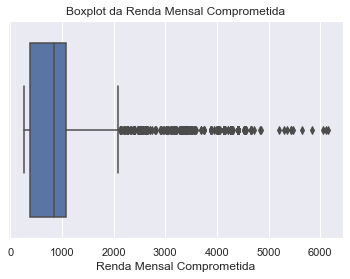

In [40]:
sns.boxplot(data=data, x='renda_comprometida')
plt.xlabel('Renda Mensal Comprometida')
plt.title('Boxplot da Renda Mensal Comprometida');

Nenhuma das distribuições segue uma distribuição normal, portanto, calcula-se a correlação se Spearman entre essas variáveis. Ainda, observa-se uma quantidade significativa de outliers na renda mensal comprometida.

In [41]:
print(f'Correlação entre Renda Mensal Livre e Performance {st.spearmanr(data.renda_livre, data.target)}')
print(f'Correlação entre Renda Mensal Comprometida e Performance {st.spearmanr(data.renda_comprometida, data.target)}')

Correlação entre Renda Mensal Livre e Performance SpearmanrResult(correlation=-0.11124817496744312, pvalue=3.4443293511182376e-24)
Correlação entre Renda Mensal Comprometida e Performance SpearmanrResult(correlation=0.14660349497909775, pvalue=5.909412344239154e-41)


A correlação entre as variáveis Renda Mensal Comprometida é positiva, seguindo o esperado pelo senso comum. A correlação entre renda livre também segue a direção esperada.

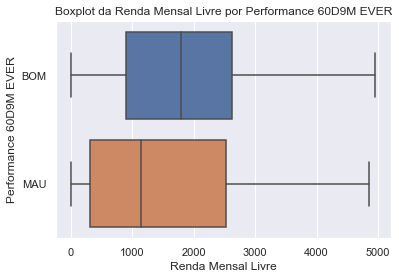

In [42]:
sns.boxplot(data=data, x='renda_livre', y=target, order=hue_order)
plt.xlabel('Renda Mensal Livre')
plt.ylabel('Performance 60D9M EVER')
plt.title('Boxplot da Renda Mensal Livre por Performance 60D9M EVER');

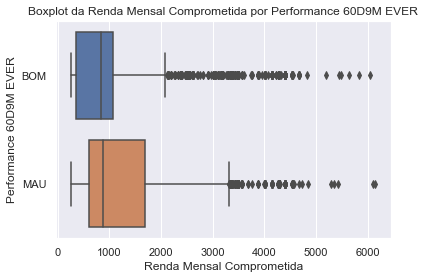

In [43]:
sns.boxplot(data=data, x='renda_comprometida', y=target, order=hue_order)
plt.xlabel('Renda Mensal Comprometida')
plt.ylabel('Performance 60D9M EVER')
plt.title('Boxplot da Renda Mensal Comprometida por Performance 60D9M EVER');

In [44]:
# Quantidade de outliers em renda comprometida
(~iqr_filter(data, 'renda_comprometida')).sum()

942

Quanto aos outliers, nenhum tratamento será feito por se tratarem de uma grande quantidade de dados comparada a quantidade total da base. Outro fator é a inexistência de outliers em renda mensal livre, que pode ser usada no lugar da renda mensal comprometida sem tratamento de outliers.

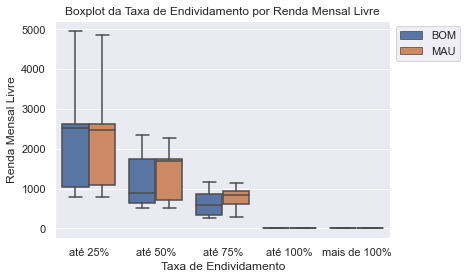

In [45]:
sns.boxplot(data=data, x='endividamento', y='renda_livre', hue=target, order=['até 25%', 'até 50%', 'até 75%', 'até 100%', 'mais de 100%'], hue_order=hue_order)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xlabel('Taxa de Endividamento')
plt.ylabel('Renda Mensal Livre')
plt.title('Boxplot da Taxa de Endividamento por Renda Mensal Livre');

### Quantidade de Cheques Sem Fundo

In [46]:
data.quantidade_de_cheques_sem_fundo.describe().to_frame()

,quantidade_de_cheques_sem_fundo
count,8269.000000
mean,0.167372
std,1.566474
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,64.000000


<AxesSubplot:xlabel='quantidade_de_cheques_sem_fundo', ylabel='Count'>

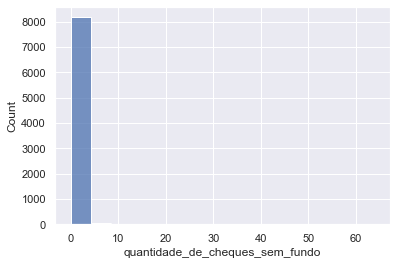

In [47]:
sns.histplot(data=data, x='quantidade_de_cheques_sem_fundo')

<AxesSubplot:xlabel='quantidade_de_cheques_sem_fundo'>

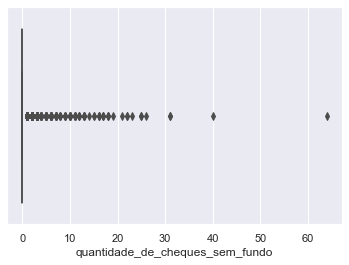

In [48]:
sns.boxplot(data=data, x='quantidade_de_cheques_sem_fundo')

In [49]:
cheques_outlier = ~iqr_filter(data, 'quantidade_de_cheques_sem_fundo')
cheques_inlier = iqr_filter(data, 'quantidade_de_cheques_sem_fundo')

In [50]:
cheques_outlier.sum()

261

In [51]:
data.loc[cheques_inlier].quantidade_de_cheques_sem_fundo.describe().to_frame()

,quantidade_de_cheques_sem_fundo
count,8008.0
mean,0.0
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,0.0


In [52]:
st.spearmanr(data.quantidade_de_cheques_sem_fundo, data.target)

SpearmanrResult(correlation=0.08391813056347568, pvalue=2.1164881611528785e-14)

A quantidade de pessoas com cheques sem fundo é tão pequena na base que os pontos que existem são considerados anormais pelo IQR. Apesar disso a correlação entre a variável e a Performance é positiva. Esse campo talvez seja descartado por ter pouco mais de 200 registros não nulos.

### Quantidade de Restritivos

In [53]:
data.quantidade_de_restritivos.describe().to_frame()

,quantidade_de_restritivos
count,8269.000000
mean,0.710727
std,1.831960
min,-7.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,35.000000


In [54]:
(data.quantidade_de_restritivos < 0).sum(), (data.quantidade_de_restritivos < 0).sum()/data.__len__()

(24, 0.0029024065787882454)

In [55]:
qtd_negativa = data[data.quantidade_de_restritivos < 0]
qtd_negativa[['quantidade_de_restritivos', 'valor_dos_restritivos']]

,quantidade_de_restritivos,valor_dos_restritivos
161,-6.0,0.0
261,-3.0,0.0
264,-4.0,0.0
311,-1.0,0.0
388,-1.0,0.0
393,-1.0,0.0
436,-1.0,0.0
1008,-1.0,0.0
1471,-1.0,0.0
1518,-1.0,0.0


Uma inconsistência é evidenciada pelo valor negativo ali listado. Um cliente não pode ter uma quantidade negativa de restritivos em seu nome. Um ainda possui valor de restritivos atrelados. Opto por removê-los da base. 

In [56]:
data = data.drop(qtd_negativa.index, axis=0)

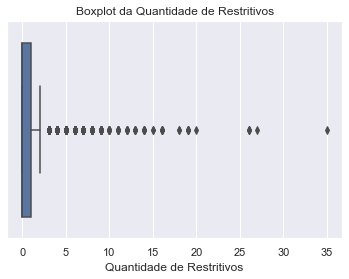

In [57]:
sns.boxplot(data=data, x='quantidade_de_restritivos')
plt.xlabel('Quantidade de Restritivos')
plt.title('Boxplot da Quantidade de Restritivos');

In [58]:
(~iqr_filter(data, 'quantidade_de_restritivos')).sum() # Quantidade de outliers em quantidade de restritivos

735

A quantidade de outliers aqui é grande e considero como uma característica do atributo. Essa característica vai se repetir nesses campos pois a maioria dos clientes não possui restritivos. Em seguida, calcula-se a correlação:

In [59]:
st.spearmanr(data.quantidade_de_restritivos, data.target)

SpearmanrResult(correlation=0.21456578623960396, pvalue=1.768773086316833e-86)

A correlação de spearman é positiva e média.

### Valor dos Restritivos

In [60]:
data.valor_dos_restritivos.describe().to_frame()

,valor_dos_restritivos
count,8245.000000
mean,1523.889751
std,9744.780035
min,0.000000
25%,0.000000
50%,0.000000
75%,147.000000
max,434837.000000


<AxesSubplot:xlabel='valor_dos_restritivos'>

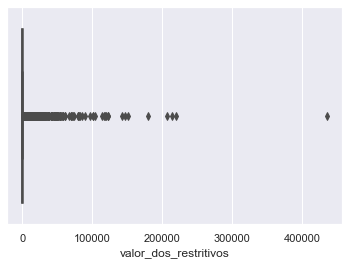

In [61]:
sns.boxplot(data=data, x='valor_dos_restritivos')

In [62]:
(~iqr_filter(data, 'valor_dos_restritivos')).sum() # Quantidade de outliers em valor dos restritivos	

1711

In [63]:
(data.valor_dos_restritivos > 100000).sum()

17

Novamente, aqui se vê uma característica da base. Aqui um outlier talvez seriam os pontos acima de 100000, 17 valores muito altos. Mesmo com a aplicação de outra filtragem pelo IQR os valores se encontram muito concentrados em um dos lados. Opto por remover os valores acima de 100000.

In [64]:
data = data.drop(data[data.valor_dos_restritivos > 100000].index, axis=0)

In [65]:
# st.spearmanr(data.loc[data.valor_dos_restritivos < 100000].valor_dos_restritivos, data.loc[data.valor_dos_restritivos < 100000].target)
st.spearmanr(data.valor_dos_restritivos, data.target)

SpearmanrResult(correlation=0.21270436692583886, pvalue=8.212395204506752e-85)

A correlação aqui também é positiva e média.

Mais uma análise de sanidade deve ser feita antes de realizar a derivação de um atributo. A análise consiste em verificar se existem registros que possuem nenhuma quantidade de restritivos, mas que possuam valores de restritivos não nulos. Se existirem, esses registros devem ser removidos.

In [66]:
# Checar se existem quantidades zeradas e valores não zerados
quantidade_zero = data.quantidade_de_restritivos == 0
valores_not_zero = data.valor_dos_restritivos != 0
(quantidade_zero & valores_not_zero).sum()

5

5 resgistros precisam ser removidos.

In [67]:
data = data.drop(data[quantidade_zero & valores_not_zero].index, axis=0)

Derivação de atributo

In [68]:
valor_quantidade_restritivos = data.valor_dos_restritivos / data.quantidade_de_restritivos
valor_quantidade_restritivos = valor_quantidade_restritivos.fillna(0)

In [69]:
valor_quantidade_restritivos.describe().to_frame()

,0
count,8223.000000
mean,595.499422
std,3514.033341
min,0.000000
25%,0.000000
50%,0.000000
75%,108.250000
max,96071.000000


<AxesSubplot:>

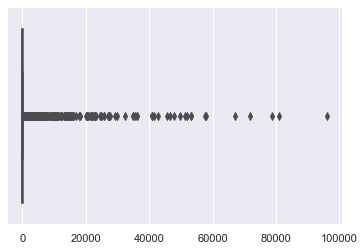

In [70]:
sns.boxplot( x=valor_quantidade_restritivos)

In [71]:
data['valor_por_restritivo'] = valor_quantidade_restritivos

In [72]:
st.spearmanr(data.valor_por_restritivo, data.target)

SpearmanrResult(correlation=0.2081539205370463, pvalue=3.559513976134106e-81)

A variável derivada `Valor Por Restritivo` também mostra uma boa correlação com a variável resposta, mas menor que as variáveis que a compõem.

### Quantidade de Protestos

In [73]:
data.quantidade_de_protestos.describe().to_frame()

,quantidade_de_protestos
count,8223.000000
mean,0.145932
std,1.154290
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,37.000000


In [74]:
(~iqr_filter(data, 'quantidade_de_protestos')).sum() # Quantidade de outliers em quantidade de protestos

431

In [75]:
st.spearmanr(data.quantidade_de_protestos, data.target)

SpearmanrResult(correlation=0.06998672389881273, pvalue=2.1077779248859585e-10)

### Valor dos Protestos

In [76]:
data.valor_dos_protestos.describe().to_frame()

,valor_dos_protestos
count,8223.000000
mean,199.283595
std,2715.462400
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,133742.000000


In [77]:
(~iqr_filter(data, 'valor_dos_protestos')).sum() # Quantidade de outliers em valor dos protestos

431

In [78]:
st.spearmanr(data.valor_dos_protestos, data.target)

SpearmanrResult(correlation=0.06932787396991404, pvalue=3.1074445412322955e-10)

Observa-se uma fraca correlação entre a variável valor dos protestos e a Performance.

In [79]:
# checar se existem quantidades zerados e valores não zerados
quantidade_zero = data.quantidade_de_protestos == 0
valores_not_zero = data.valor_dos_protestos != 0
(quantidade_zero & valores_not_zero).sum()

0

In [80]:
#derivação de variável
valor_por_protesto = data.valor_dos_protestos / data.quantidade_de_protestos
valor_por_protesto = valor_por_protesto.fillna(0)
data['valor_por_protesto'] = valor_por_protesto

In [81]:
st.spearmanr(data.valor_por_protesto, data.target)

SpearmanrResult(correlation=0.06877706105209157, pvalue=4.287046917317038e-10)

## Criação do modelo de ML

Para criação do modelo considero dois algoritmos: SVM e Random Forest. São modelos não paramétricos e amplamente utilizados. Os dados poderiam ser adequados a uma distribuição gaussiana, mas possibilitaria e exigiria uma análise muito mais robusta dos atributos e suas importâncias para um modelo. Com o tempo disponível agora considero essas duas possibilidades de algoritmos de ML.

In [83]:
random_state = np.random.RandomState(15)

### Preparação dos dados

In [84]:
data.columns

Index(['safra', 'estado', 'renda_mensal', 'endividamento',
       'quantidade_de_cheques_sem_fundo', 'quantidade_de_restritivos',
       'valor_dos_restritivos', 'quantidade_de_protestos',
       'valor_dos_protestos', 'performance_60d9m_ever', 'regiao', 'target',
       'renda_livre', 'renda_comprometida', 'valor_por_restritivo',
       'valor_por_protesto'],
      dtype='object')

In [85]:
y = data.target # Alvo da classificação

In [86]:
X = data.drop(['target', 'performance_60d9m_ever'], axis=1)  # Dados de entrada

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state, stratify=y)

### Criação das Pipelines

In [113]:
categorical = [
    'safra', 
    # 'estado', 
    # 'endividamento', 
    'regiao'
    ]
numerical = [
    'renda_mensal', 
    # 'quantidade_de_cheques_sem_fundo', 
    'quantidade_de_restritivos',
    'valor_dos_restritivos', 
    'quantidade_de_protestos',
    # 'valor_dos_protestos',
    'renda_livre', 
    'renda_comprometida', 
    'valor_por_restritivo',
    'valor_por_protesto'
    ]

ct = ColumnTransformer(
    [
        ('categorical', OneHotEncoder(categories='auto', handle_unknown='ignore'), categorical),
        ('numerical', StandardScaler(), numerical),
    ]
)

rf_model = Pipeline(
    [
        ('columnTransform', ct),
        ('forest', RandomForestClassifier(n_estimators=300, random_state=random_state, n_jobs=-1))
    ]
)

### Treinamento e teste do modelo e dos atributos

0.6050165456383858


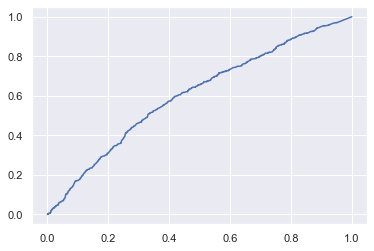

In [114]:
rf_model.fit(X_train, y_train)
y_hat = rf_model.predict_proba(X_test)[:, 1]
print(roc_auc_score(y_test, y_hat))
fpr, tpr, thresholds = roc_curve(y_test, y_hat)
plt.plot(fpr, tpr)

Desempenho do Random Forestl para um teste incial. O desempenho na detecção da classe MAU está baixo. Tentarei um GridSearch para melhorar o desempenho.

In [ ]:
rf_gs = GridSearchCV(
    estimator=rf_model,
    param_grid={
        'forest__n_estimators': [250, 500],
        'forest__criterion': ['gini', 'entropy'],
        'forest__max_depth': [7, None],
        'forest__min_samples_leaf': [1, 7],
        'forest__max_features': [0.5, 1.0],
    },
    scoring='roc_auc',
    cv=3,
    verbose=1,
    n_jobs=1
)
rf_gs.fit(X_train, y_train)

In [96]:
rf_gs.best_score_

0.6513200439338083

0.65 é uma melhora em relação a antes da busca. Vejamos os melhores parametros:

In [97]:
rf_gs.best_params_

{'forest__criterion': 'gini',
 'forest__max_depth': 7,
 'forest__max_features': 0.5,
 'forest__min_samples_leaf': 7,
 'forest__n_estimators': 500}

In [116]:
y_hat = rf_gs.predict_proba(X_test)[:, 1]
print(roc_auc_score(y_test, y_hat))

0.6472175751447743


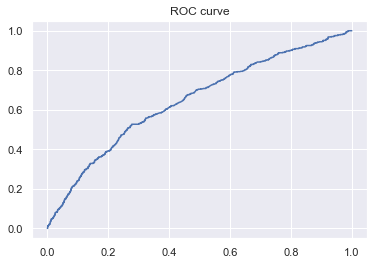

In [119]:
fpr, tpr, thresholds = roc_curve(y_test, y_hat)
plt.plot(fpr, tpr)
plt.title('ROC curve');

Como visto, a busca teve impactos positivos no desempenho do modelo do conjunto de teste.

## Conclusão

Para uma análise rápida e focada em uma variável resposta, o Random Forest é um modelo de ML que geralmente se adapta bem a qualquer tipo de problema. O GridSearch possibilitou uma melhor performance do modelo encontrando um melhor conjunto de parametros. Com mais tempo e recursos as outras variáveis respostas poderiam ser melhor exploradas com mais modelos, mais parâmetros e mais técnicas de análise.